In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline


In [2]:
# Data loading
directory = "../dataset/FashionMNIST"
tr_fmnist = datasets.FashionMNIST(directory, train=True, download=True)
val_fmnist = datasets.FashionMNIST(directory, train=False, download=True)

tr_data = tr_fmnist.data
tr_targets = tr_fmnist.targets

val_data = val_fmnist.data
val_targets = val_fmnist.targets

# general statistics
print(f"Shape of training dataset: {tr_data.shape}, targets: {tr_targets.shape}")
print(f"Shape of validation dataset: {val_data.shape}, targets:{val_targets.shape}")

ConnectionResetError: [Errno 104] Connection reset by peer

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/225
        x = x.view(-1, 28*28)
        self.x, self.y = x, y
    
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)

    def __len__(self):
        return len(self.x)

In [6]:
def get_data():
    # trainging dataloader
    tr_ds = FMNISTDataset(tr_data, tr_targets)
    tr_dl = DataLoader(tr_ds, batch_size=32, shuffle=True)
    # validation dataloader
    val_ds = FMNISTDataset(val_data, val_targets)
    val_dl = DataLoader(val_ds, batch_size=len(val_targets), shuffle=False)
    return tr_dl, val_dl

def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(model.parameters(), lr=0.001)
    return model, loss_fn, optim


In [8]:
def model_training(x, y, model, loss_fn, optim):
    model.train()
    predictions = model(x)
    loss = loss_fn(predictions, y)
    loss.backward()
    optim.step()
    optim.zero_grad()
    return loss.item()

def model_accuracy(x,y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
        max_values, argmaxes = prediction.max(-1)
        is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def evaluate_model(x, y, model, loss_fn):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [11]:
tr_dl, val_dl = get_data()
model, loss_fn, optim = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(5):
    tr_epoch_losses, tr_epoch_accuracies = [], []
    for ix , batch in enumerate(iter(tr_dl)):
        x, y = batch
        loss = model_training(x, y, model, loss_fn, optim)
        is_correct = model_accuracy(x, y, model)
        tr_epoch_losses.append(loss)
        tr_epoch_accuracies.extend(is_correct)
    
    loss = np.array(tr_epoch_losses).mean()
    accuracy = np.array(tr_epoch_accuracies).mean()

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        validation_loss = evaluate_model(x, y, model, loss_fn)
        val_is_correct = model_accuracy(x, y, model)
    
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(loss)
    train_accuracies.append(accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)


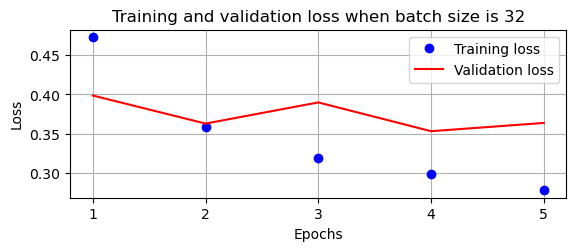

/tmp/ipykernel_35232/2293199064.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \


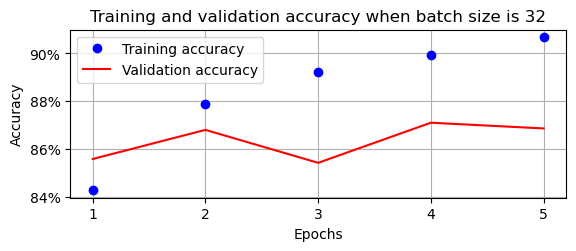

: 

In [12]:
epochs = np.arange(1, 6)
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', \
label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', \
label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()